# Jelly roll model

In this notebook we show how to set up and solve the "two-potential" model from "Homogenisation of spirally-wound high-contrast layered materials", S. Psaltis, R. Timms, C.P. Please, S.J. Chapman, SIAM Journal on Applied Mathematics, 2020.

We consider a spirally-wound cell, such as the common 18650 lithium-ion cell. In practice these cells are constructed by rolling a sandwich of layers containing the active cathode, positive current collector, active cathode, separator, active anode, negative current collector, active anode, and separator. The "two-potential" model consists of an equation for the potential $\phi^\pm$ in each current collector. The potential difference drives a current $I$ through the electrode/separator/electrode sandwich (which we refer to as the "active material" in the original paper). Thus, in non-dimensional form, the model is 

$$ \frac{\delta^+\sigma^+}{2\pi^2}\frac{1}{r}\frac{\mathrm{d}}{\mathrm{d}r}\left(\frac{1}{r}\frac{\mathrm{d}\phi^+}{\mathrm{d}r}\right) + 2I(\phi^+-\phi^-) = 0,$$
$$ \frac{\delta^-\sigma^-}{2\pi^2}\frac{1}{r}\frac{\mathrm{d}}{\mathrm{d}r}\left(\frac{1}{r}\frac{\mathrm{d}\phi^-}{\mathrm{d}r}\right) - 2I(\phi^+-\phi^-) = 0,$$
with boundary conditions 
$$ \frac{\mathrm{d}\phi^+}{\mathrm{d}r}(r=r_0) = 0, \quad \phi^+(r=1) = 1, \quad \phi^-(r=0) = 0, \quad \frac{\mathrm{d}\phi^-}{\mathrm{d}r}(r=1) = 0.$$

For a complete description of the model and parameters, please refer to the original paper.

It can be shown that the active material can be modelled using any 1D battery model we like to describe the electrochemical/thermal behaviour in the electrode/separator/electrode sandwich. Such functionality will be added to PyBaMM in a future release and will enable efficient simulations of jelly roll cells.  


## Two-potential resistor model
In this section we consider a simplified model in which we ignore the details of the anode, cathode and separator, and treat them as a single region of active material, modelled as an Ohmic conductor, with two such regions per winding. In this case the model becomes 

$$ \frac{\delta^+\sigma^+}{2\pi^2}\frac{1}{r}\frac{\mathrm{d}}{\mathrm{d}r}\left(\frac{1}{r}\frac{\mathrm{d}\phi^+}{\mathrm{d}r}\right) + \frac{2\sigma^{a}(\phi^--\phi^+)}{l\epsilon^4} = 0,$$
$$ \frac{\delta^-\sigma^-}{2\pi^2}\frac{1}{r}\frac{\mathrm{d}}{\mathrm{d}r}\left(\frac{1}{r}\frac{\mathrm{d}\phi^-}{\mathrm{d}r}\right) - \frac{2\sigma^{a}(\phi^--\phi^+)}{l\epsilon^4} = 0,$$
along with the same boundary conditions.

We begin by importing PyBaMM along with some other useful packages

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np 
from numpy import pi
import matplotlib.pyplot as plt 


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


First we will define the parameters in the model. Note the model is posed in non-dimensional form.

In [2]:
N = pybamm.Parameter("Number of winds")
r0 = pybamm.Parameter("Inner radius")
eps = (1 - r0) / N  # ratio of sandwich thickness to cell radius
delta = pybamm.Parameter("Current collector thickness")
delta_p = delta  # assume same thickness
delta_n = delta  # assume same thickness
l = 1/2 - delta_p - delta_n  # active material thickness
sigma_p = pybamm.Parameter("Positive current collector conductivity")
sigma_n = pybamm.Parameter("Negative current collector conductivity")
sigma_a = pybamm.Parameter("Active material conductivity")

Next we define our geometry and model

In [3]:
# geometry
r = pybamm.SpatialVariable("radius", domain="cell", coord_sys="cylindrical polar")
geometry = {"cell": {r: {"min": r0, "max": 1}}}

# model
model = pybamm.BaseModel()
phi_p = pybamm.Variable("Positive potential", domain="cell")
phi_n = pybamm.Variable("Negative potential", domain="cell")

A_p = (2 * sigma_a / eps ** 4 / l) / (delta_p * sigma_p / 2 / pi ** 2)
A_n = (2 * sigma_a / eps ** 4 / l) / (delta_n * sigma_n / 2 / pi ** 2)
model.algebraic = {
        phi_p: pybamm.div((1 / r ** 2) * pybamm.grad(phi_p)) + A_p * (phi_n - phi_p),
        phi_n: pybamm.div((1 / r ** 2) * pybamm.grad(phi_n)) - A_n * (phi_n - phi_p),
}

model.boundary_conditions = {
    phi_p: {
        "left": (0, "Neumann"),
        "right": (1, "Dirichlet"),
    },
    phi_n: {
        "left": (0, "Dirichlet"),
        "right": (0, "Neumann"),
    }    
}

model.initial_conditions = {phi_p: 1, phi_n: 0}  # initial guess for solver

model.variables = {"Negative potential": phi_n, "Positive potential": phi_p}

Next we provide values for our parameters, and process our geometry and model, thus replacing the `Parameter` symbols with numerical values

In [4]:
params = pybamm.ParameterValues(
    {
        "Number of winds":20,
        "Inner radius": 0.25,
        "Current collector thickness": 0.05,
        "Positive current collector conductivity": 5e6,
        "Negative current collector conductivity": 5e6,
        "Active material conductivity": 1,
    }
)
params.process_geometry(geometry)
params.process_model(model)

We choose to discretise in space using the Finite Volume method on a uniform grid

In [5]:
# mesh
submesh_types = {"cell": pybamm.Uniform1DSubMesh}
var_pts = {r: 100}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
# method
spatial_methods = {"cell": pybamm.FiniteVolume()}
# discretise
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

We can now solve the model

In [6]:
# solver 
solver = pybamm.CasadiAlgebraicSolver()
solution = solver.solve(model)

The model gives the homogenised potentials in the negative a positive current collectors. Interestingly, the solid potential has microscale structure, varying linearly in the active material. In order to see this we need to post-process the solution and plot the potential as a function of radial position, being careful to capture the spiral geometry.  

In [7]:
# extract numerical parameter values
# Note: this overrides the definition of the `pybamm.Parameter` objects
N = params.evaluate(N)
r0 = params.evaluate(r0)
eps = params.evaluate(eps)
delta = params.evaluate(delta)

In [8]:
# post-process homogenised potential 
phi_n = solution["Negative potential"]
phi_p = solution["Positive potential"]


def alpha(r):
    return 2 * (phi_n(r=r) - phi_p(r=r))


def phi_am1(r, theta):
    # careful here - phi always returns a column vector so we need to add a new axis to r to get the right shape 
    return alpha(r) * (r[:,np.newaxis]/eps - r0/eps - delta - theta / 2 / pi) / (1 - 4*delta) + phi_p(r=r)


def phi_am2(r, theta):
    # careful here - phi always returns a column vector so we need to add a new axis to r to get the right shape 
    return alpha(r) * (r0/eps + 1 - delta + theta / 2 / pi - r[:,np.newaxis]/eps) / (1 - 4*delta) + phi_p(r=r)

In [9]:
# define spiral 


def spiral_pos_inner(t):
    return r0 - eps * delta + eps * t / (2 * pi)


def spiral_pos_outer(t):
    return r0 + eps * delta + eps * t / (2 * pi)


def spiral_neg_inner(t):
    return r0 - eps * delta + eps / 2 + eps * t / (2 * pi)


def spiral_neg_outer(t):
    return r0 + eps * delta + eps / 2 + eps * t / (2 * pi)


def spiral_am1_inner(t):
    return r0 + eps * delta + eps * t / (2 * pi)


def spiral_am1_outer(t):
    return r0 - eps * delta + eps / 2 + eps * t / (2 * pi)


def spiral_am2_inner(t):
    return r0 + eps * delta + eps / 2 + eps * t / (2 * pi)


def spiral_am2_outer(t):
    return r0 - eps * delta + eps + eps * t / (2 * pi)

In [10]:
# Setup fine mesh with nr points per layer
nr = 10
rr = np.linspace(r0, 1, nr)
tt = np.arange(0, (N+1)*2*pi, 2*pi)
# N+1 winds of pos c.c.
r_mesh_pos = np.zeros((len(tt),len(rr)))
for i in range(len(tt)):
    r_mesh_pos[i,:] = np.linspace(spiral_pos_inner(tt[i]), spiral_pos_outer(tt[i]), nr)
# N winds of neg, am1, am2
r_mesh_neg = np.zeros((len(tt)-1, len(rr)))
r_mesh_am1 = np.zeros((len(tt)-1, len(rr)))
r_mesh_am2 = np.zeros((len(tt)-1, len(rr)))
for i in range(len(tt)-1):
    r_mesh_am2[i,:] = np.linspace(spiral_am2_inner(tt[i]), spiral_am2_outer(tt[i]), nr)
    r_mesh_neg[i,:] = np.linspace(spiral_neg_inner(tt[i]), spiral_neg_outer(tt[i]), nr)
    r_mesh_am1[i,:] = np.linspace(spiral_am1_inner(tt[i]), spiral_am1_outer(tt[i]), nr)
# Combine and sort    
r_total_mesh = np.vstack((r_mesh_pos,r_mesh_neg,r_mesh_am1, r_mesh_am2))
r_total_mesh = np.sort(r_total_mesh,axis=None)

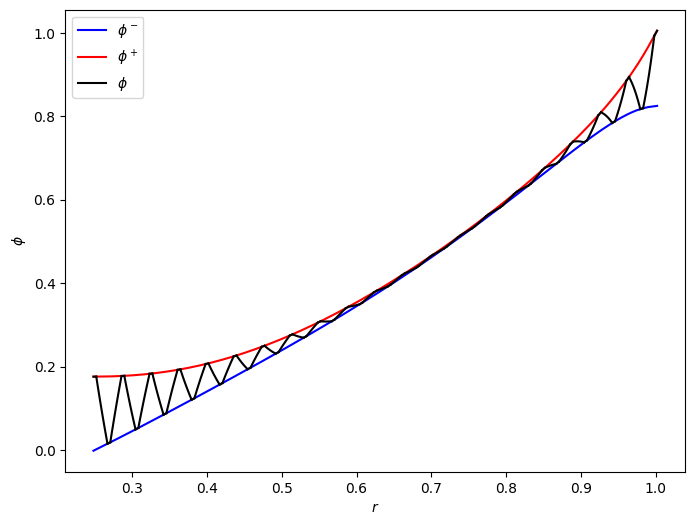

In [11]:
# plot homogenised potential 
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(r_total_mesh, phi_n(r=r_total_mesh), 'b', label=r"$\phi^-$")
ax.plot(r_total_mesh, phi_p(r=r_total_mesh), 'r', label=r"$\phi^+$")
for i in range(len(tt)):
    ax.plot(r_mesh_pos[i,:], phi_p(r=r_mesh_pos[i,:]), 'k', label=r"$\phi$" if i ==0 else "")
for i in range(len(tt)-1):
    ax.plot(r_mesh_neg[i,:], phi_n(r=r_mesh_neg[i,:]), 'k')
    ax.plot(r_mesh_am1[i,:], phi_am1(r_mesh_am1[i,:], tt[i]), 'k')
    ax.plot(r_mesh_am2[i,:], phi_am2(r_mesh_am2[i,:], tt[i]), 'k')
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$\phi$")
ax.legend();

## References

The relevant papers for this notebook are:

In [12]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). Journal of Open Research Software, 9(1):14, 2021. doi:10.5334/jors.309.

